# Initial Set Up

In [27]:
#----------------------------------------------------------------------
    # Libraries
#----------------------------------------------------------------------

import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import datetime as dt
import requests
import zipfile
import io

In [28]:
#----------------------------------------------------------------------
    # Constants for all portfolios
#----------------------------------------------------------------------

# start and end dates of observed
startDate = '2018-01-05'
# sets the start date to the nearest monday to make aligining data easier
startDate = pd.to_datetime(startDate) - pd.offsets.Week(weekday=0)
endDate = '2024-10-01'

# set the initial budget to invest
initialVal = 100000

# set the length of investment period (in weeks)
investPeriod = 26

In [29]:
#----------------------------------------------------------------------
    # Finding adj close data
#----------------------------------------------------------------------

# function to find the adj close data for the given tickers and time period
def find_adj_close(tickers, startDate, endDate):
    # pull data from yfinance
    adjClose = yf.download(tickers, start=startDate, end=endDate, interval = '1wk')['Adj Close']

    # format the data to work with the optimization structure
    adjClose.reset_index(inplace=True)
    #title the date column
    adjClose.columns = ['Date'] + tickers
    # format the date column
    adjClose['Date'] = adjClose['Date'].dt.strftime('%Y-%m-%d')

    # set date as the index
    adjClose.set_index('Date', inplace=True)

    # set the dates to pandas dates
    adjClose.index = pd.to_datetime(adjClose.index)

    # define the tickers off adjClose so it's compatible later
    tickers = adjClose.columns

    return adjClose, tickers

In [30]:
#----------------------------------------------------------------------
    # Finding factor returns
#----------------------------------------------------------------------

# function to find the factor return data for the given tickers and time period
def find_factor_ret(startDate, endDate):
    # URLs for factor data
    fiveFactorURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_TXT.zip'
    momURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_daily_TXT.zip'
    STRevURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_ST_Reversal_Factor_daily_TXT.zip'
    LTRevURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_LT_Reversal_Factor_daily_TXT.zip'

    # function to pull factor data from the web
    def pull_factor_data(url, skipRows):
        response = requests.get(url)
        # pull the data from the site
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # get the name of the file
            fileName = z.namelist()[0]
        
            # read the .txt file
            with z.open(fileName) as file:
                return pd.read_csv(file, skiprows=skipRows, encoding='ISO-8859-1',  sep='\\s+', on_bad_lines='skip')

    # pulling from Ken French database
    fiveFactorRet = pull_factor_data(fiveFactorURL, 3)
    momRet = pull_factor_data(momURL, 13)
    STRevRet = pull_factor_data(STRevURL, 13)
    LTRevRet = pull_factor_data(LTRevURL, 13)
    # concatenating the factor data
    dailyFactorRet = pd.concat([fiveFactorRet, momRet, STRevRet, LTRevRet])

    # format the data to work with the optimization structure
    dailyFactorRet.reset_index(inplace=True)
    # title the date column
    dailyFactorRet.columns = ['Date'] + dailyFactorRet.columns.tolist()[1:]
    # format the date column
    dailyFactorRet['Date'] = pd.to_datetime(dailyFactorRet['Date'], format='%Y%m%d')
    # filter based on start and end date (note including a few days before start date in order to do the weekly sums)
    dailyFactorRet = dailyFactorRet[(dailyFactorRet['Date'] >= pd.to_datetime(startDate) - pd.DateOffset(days=6)) & (dailyFactorRet['Date'] <= endDate)]

    # data is daily but it needs to be weekly
    # make a weekly data frame
    factorRet = pd.DataFrame()

    # sum daily data for each week
    for weekEnd in pd.date_range(start=startDate, end=endDate, freq='W-MON'):
        # figure out the week start
        weekStart = weekEnd - pd.DateOffset(days=6)
        # filter the data for the particular week
        weekData = dailyFactorRet[(dailyFactorRet['Date'] >= weekStart) & (dailyFactorRet['Date'] <= weekEnd)]
        # sum up the data for that week
        weeklySum = weekData[dailyFactorRet.columns[1:]].sum()
        # format it so it can be added to the data frame
        weekDataFrame = pd.DataFrame([[weekEnd] + weeklySum.tolist()], columns=['Date'] + weeklySum.index.tolist())
        # add the weekly sum to the data frame
        factorRet = pd.concat([factorRet, weekDataFrame])

    # set date as the index
    factorRet.set_index('Date', inplace=True)

    # set the dates to pandas dates
    factorRet.index = pd.to_datetime(factorRet.index)

    # divide the factor returns by 100
    factorRet = factorRet/100

    # separate out the rf and factor returns
    riskFree = factorRet['RF']
    factorRet = factorRet.loc[:,factorRet.columns != 'RF']

    # define the dates off the factor returns so it's compatible later
    dates = factorRet.index

    return riskFree, factorRet, dates

# Test Optimization Strategies

In [31]:
#----------------------------------------------------------------------
    # Testing optimization strategies
#----------------------------------------------------------------------

# function to test given optimization strategies and constraints
def test_optimization(adjClose, tickers, factorRet, riskFree, dates, short):    
    # calculate the stocks weekly excess returns
    returns = adjClose.pct_change(1)

    # adjust returns based on risk free rate
    returns = returns - np.diag(riskFree.values) @ np.ones_like(returns.values)

    # set testing period start
    testStart = returns.index[0] + pd.offsets.DateOffset(weeks=156)

    # calculate end of first testing period
    testEnd = testStart + pd.offsets.DateOffset(weeks=investPeriod) - pd.offsets.DateOffset(weeks=1)

    # set the end of calibration period
    calEnd = testStart

    # calculate the total number of investment periods
    NoPeriods = math.ceil((returns.index[-1] - testStart).days // (investPeriod * 7))

    # calculate the number of assets
    n = len(tickers)

    # preallocate space for the portfolio weights (x0 will be used to calculate the turnover rate)
    x = np.zeros([n, NoPeriods])
    x0 = np.zeros([n, NoPeriods])

    # preallocate space for the portfolio per period value and turnover
    currentVal = np.zeros([NoPeriods, 1])
    turnover = np.zeros([NoPeriods, 1])

    # initiate counter for the number of observations per investment period
    toDay = 0

    # measure runtime: start the clock
    start_time = time.time()

    # empty list to measure the value of the portfolio over the period
    portfValue = []

    # loop over testing periods
    for t in range(NoPeriods):
        # subset the returns and factor returns corresponding to the current calibration period.
        periodReturns = returns[returns.index <= calEnd]
        periodFactRet = factorRet[factorRet.index <= calEnd]

        # calculate the current prices
        current_price_idx = (calEnd - pd.offsets.DateOffset(weeks=1) <= adjClose.index)&(adjClose.index < calEnd)
        currentPrices = adjClose[current_price_idx]

        # subset the prices corresponding to the current out-of-sample test period.
        periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
        periodPrices = adjClose[periodPrices_idx]

        # check that period is the right length and that there is only 1 set of current prices
        assert len(periodPrices) == investPeriod
        assert len(currentPrices) == 1
        
        # set the initial value of the portfolio or update the portfolio value
        if t == 0:
            currentVal[0] = initialVal
        else:
            currentVal[t] = currentPrices @  NoShares.values.T
            # store the current asset weights (before optimization takes place)
            x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

        #----------------------------------------------------------------------
            # Portfolio optimization
        #----------------------------------------------------------------------
        
        # run the project function for this period
        x[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], short)

        # calculate the turnover rate
        if t > 0:
            turnover[t] = np.sum(np.abs(x[:,t] - x0[:,t]))

        # calculate the number of shares your portfolio holds per stock
        NoShares = x[:,t]*currentVal[t]/currentPrices

        # update the counter for the number of observations per investment period
        fromDay = toDay
        toDay = toDay + len(periodPrices)

        # weekly portfolio value during the out-of-sample window
        portfValue.append(periodPrices@ NoShares.values.T)

        # update the calibration and out-of-sample test periods
        testStart = testStart + pd.offsets.DateOffset(weeks=investPeriod)
        testEnd   = testStart + pd.offsets.DateOffset(weeks=investPeriod) - pd.offsets.DateOffset(weeks=1)
        calEnd    = testStart

    portfValue = pd.concat(portfValue, axis = 0)
    end_time = time.time()
    portWeights = x

    return portWeights, portfValue, turnover, start_time, end_time, riskFree

In [32]:
#--------------------------------------------------------------------------
    # Test a full portfolio
#-----------------------------------------------------------------------

# function to test a given portfolio and strategy
def test_portfolio(tickers, strategy, short):
    # find the adj close details
    findAdjCloseResults = find_adj_close(tickers, startDate, endDate)
    adjClose = findAdjCloseResults[0]
    tickers = findAdjCloseResults[1]

    # find factor return details
    findFactorRetResults = find_factor_ret(startDate,endDate)
    riskFree = findFactorRetResults[0]
    factorRet = findFactorRetResults[1]
    dates = findFactorRetResults[2]

    # test the optimization
    testOptimizationResults = test_optimization(adjClose, tickers, factorRet, riskFree, dates, short)
    portWeights = testOptimizationResults[0]
    portfValue = testOptimizationResults[1]
    turnover = testOptimizationResults[2]
    start_time = testOptimizationResults[3]
    end_time = testOptimizationResults[4]
    riskFree = testOptimizationResults[5]

    return portWeights, portfValue, turnover, start_time, end_time, riskFree, tickers

# Results

In [33]:
#--------------------------------------------------------------------------
    # Calculate elasped time, sharpe ratio, and turnover
#--------------------------------------------------------------------------

# function to print the portfolio results
def portfolio_results(portfValue, turnover, riskFree, start_time, end_time):
    # calculate the observed portfolio returns
    portfRets = portfValue.pct_change(1).iloc[1:,:]

    # calculate the portfolio excess returns
    portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

    # calculate the portfolio Sharpe ratio
    SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

    # calculate the average turnover rate
    avgTurnover = np.mean(turnover[1:])

    # print Sharpe ratio and Avg. turnover
    print("Elasped time is "+ str(end_time - start_time) + ' seconds')
    print('Sharpe ratio: ', str(SR[0]))
    print('Avg. turnover: ', str(avgTurnover))

In [48]:
#--------------------------------------------------------------------------
    # Portfolio wealth evolution & weights plot
#--------------------------------------------------------------------------

# function to display plots of hte portfolio results
def portfolio_plots(portfValue, portWeights, tickers):
    # plot the portfolio wealth
    fig = plt.figure(1)
    portfValue.plot(
        title='Portfolio Wealth Evolution',
        ylabel='Total Wealth',
        figsize=(6, 3),
        legend=False
    )

    # convert portWeights to a DataFrame with rows as rebalance periods and columns as tickers
    portWeights = pd.DataFrame(portWeights, index=tickers).T

    # separate long and short positions
    long_weights = portWeights.where(portWeights >= 0)
    short_weights = portWeights.where(portWeights < 0)

    # create a new figure for portfolio weights
    fig2 = plt.figure(2, figsize=(8, 4))

    # plot long weights as positive (above the x-axis)
    long_weights.plot.area(
        title='Portfolio Weights (Long)',
        ylabel='Weights',
        xlabel='Rebalance Period',
        figsize=(8, 4),
        legend=True,
        stacked=True
    )

    # adjust the legend and layout
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Tickers", ncol = int(len(tickers)/15))
    plt.title('Portfolio Weights (Long Positions)')
    plt.xlabel('Rebalance Period')
    plt.ylabel('Weights')

    # overlay short weights as negative (below the x-axis)
    (-short_weights).plot.area(
        title='Portfolio Weights (Short)',
        ylabel='Weights',
        xlabel='Rebalance Period',
        figsize=(8, 4),
        legend=True,
        stacked=True
    )

    # adjust the legend and layout
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Tickers", ncol = int(len(tickers)/15))
    plt.title('Portfolio Weights (Short Positions)')
    plt.xlabel('Rebalance Period')
    plt.ylabel('Weights')

    # Show the plots
    plt.show()

In [35]:
#--------------------------------------------------------------------------
    # Portfolio wealth evolution & weights plot
#--------------------------------------------------------------------------

def test_and_results(tickers, strategy, short):
    portResults = test_portfolio(tickers, strategy, short)
    portWeights = portResults[0]
    portfValue = portResults[1]
    turnover = portResults[2]
    start_time = portResults[3]
    end_time = portResults[4]
    riskFree = portResults[5]
    tickers = portResults[6]

    portfolio_results(portfValue, turnover, riskFree, start_time, end_time)
    portfolio_plots(portfValue, portWeights, tickers)

    return portWeights, portfValue, turnover, start_time, end_time, tickers, strategy


# Testing Strategies

[*********************100%***********************]  15 of 15 completed


Elasped time is 0.1886577606201172 seconds
Sharpe ratio:  0.11107919588942047
Avg. turnover:  0.6074011628152415


<Figure size 640x480 with 0 Axes>

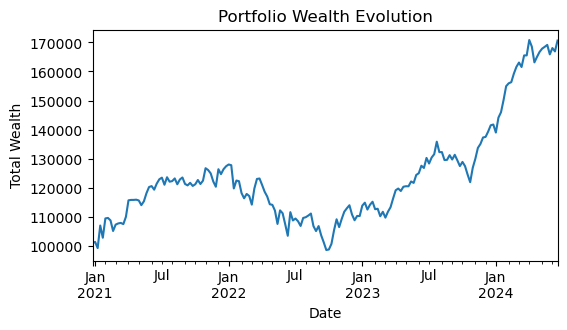

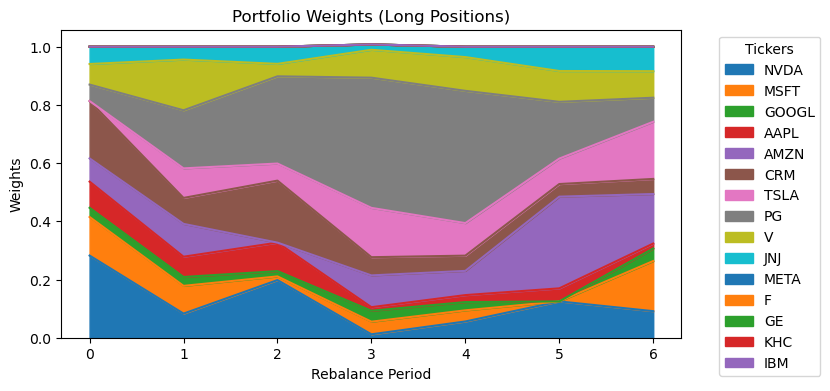

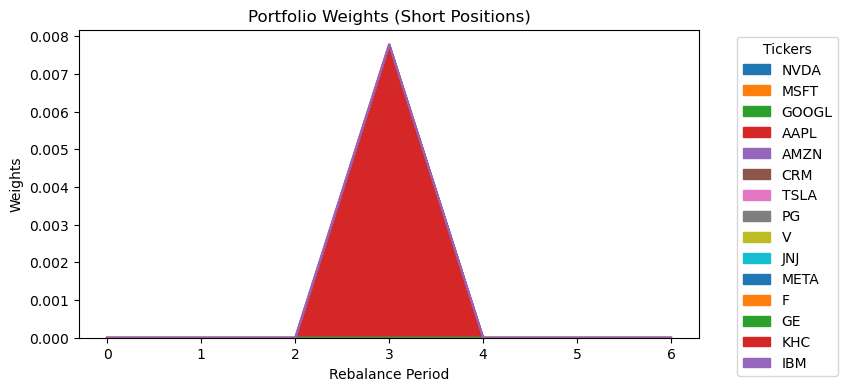

In [ ]:
# ChatGPT 15 Stock Portfolio
tickersChatGPT15 = [
    'NVDA', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'CRM', 'TSLA', 'PG', 'V', 'JNJ', 'META', 'F', 'GE', 'KHC', 'IBM'
]

short = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 10 long
    1, 1, 1, 1, 1  # 5 short
]


ChatGPT15Results = test_and_results(tickersChatGPT15,"", short)

[*********************100%***********************]  30 of 30 completed


Elasped time is 0.228287935256958 seconds
Sharpe ratio:  0.12266136295893428
Avg. turnover:  0.5301769001925606


<Figure size 640x480 with 0 Axes>

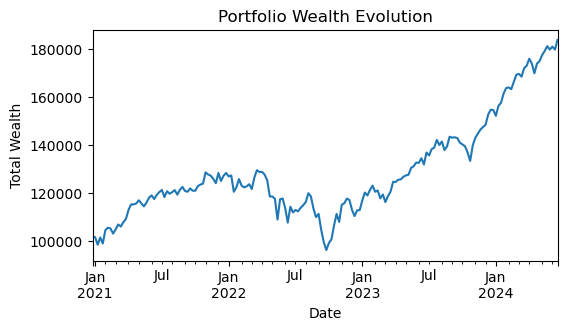

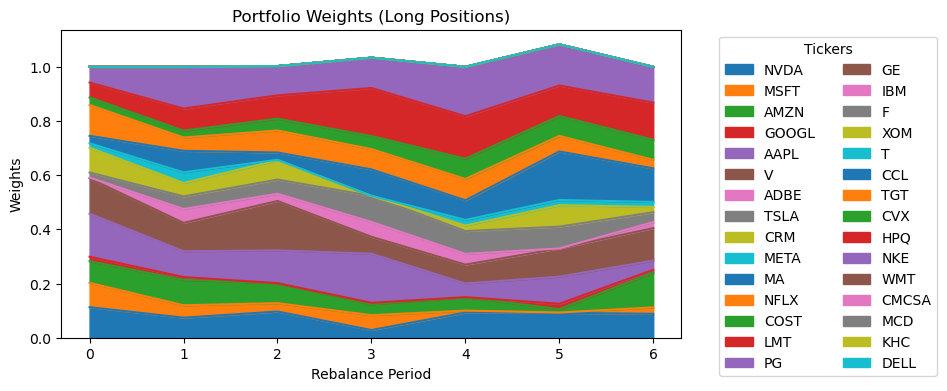

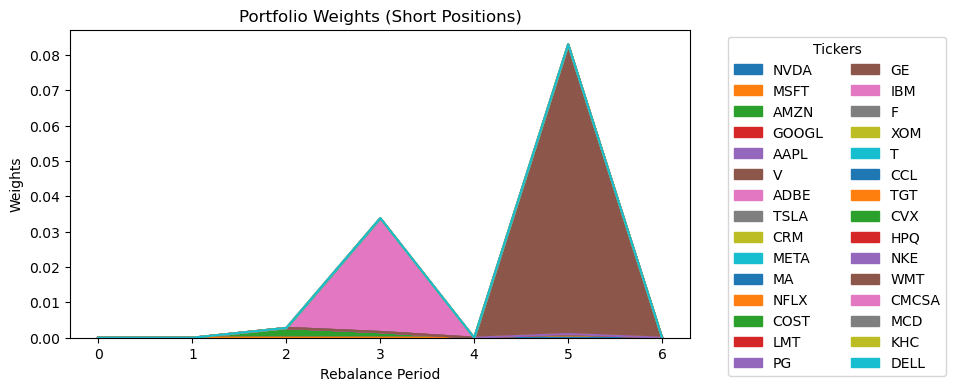

In [ ]:
# ChatGPT 30 Stock Portfolio
tickersChatGPT30 = [
    'NVDA', 'MSFT', 'AMZN', 'GOOGL', 'AAPL', 'V', 'ADBE', 'TSLA', 'CRM', 'META',
    'MA', 'NFLX', 'COST', 'LMT', 'PG', 'GE', 'IBM', 'F', 'XOM', 'T', 
    'CCL', 'TGT', 'CVX', 'HPQ', 'NKE', 'WMT', 'CMCSA', 'MCD', 'KHC', 'DELL'
]

short = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 15 long
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 # 15 short
]

ChatGPT30Results = test_and_results(tickersChatGPT30,"", short)

[*********************100%***********************]  45 of 45 completed


Elasped time is 0.2835516929626465 seconds
Sharpe ratio:  0.09071164295102216
Avg. turnover:  0.7407032642884955


<Figure size 640x480 with 0 Axes>

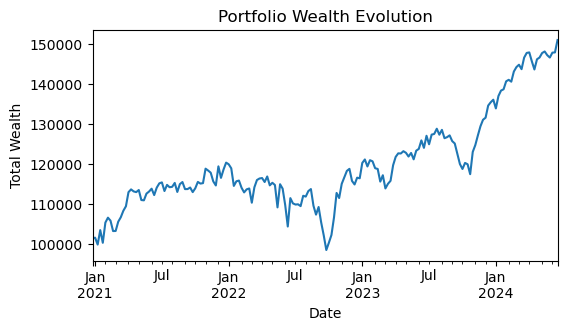

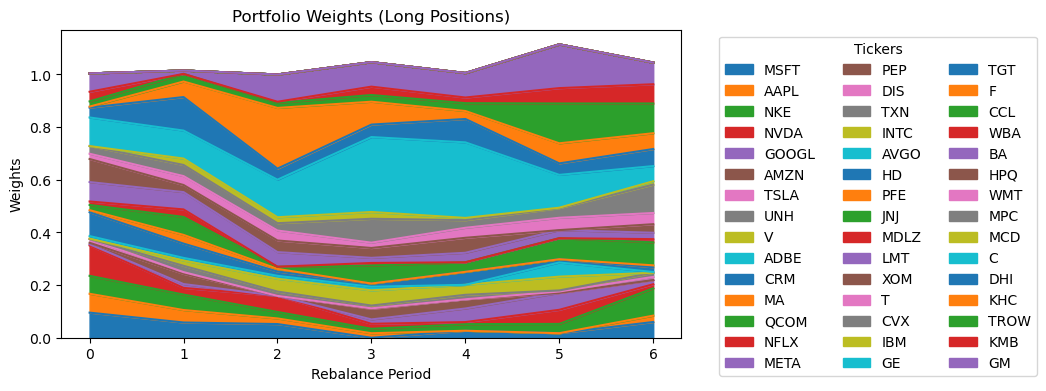

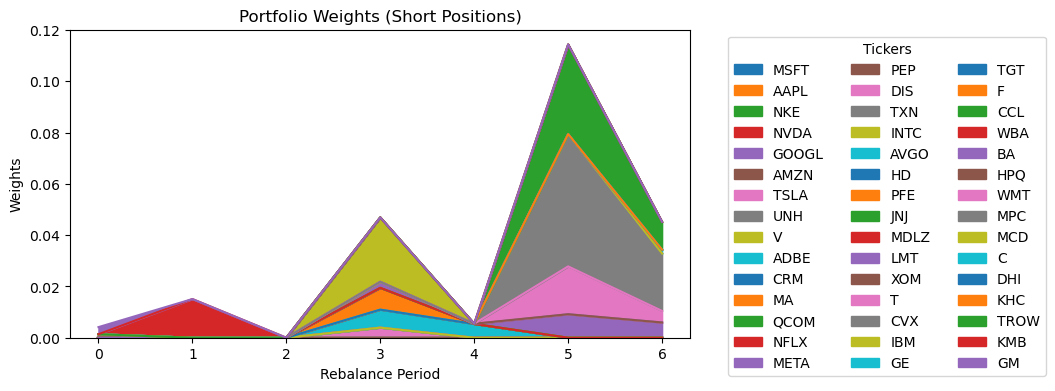

In [50]:
# ChatGPT 30 Stock Portfolio
tickersChatGPT45 = [
    'MSFT', 'AAPL', 'NKE', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'UNH', 'V', 'ADBE', 
    'CRM', 'MA', 'QCOM', 'NFLX', 'META', 'PEP', 'DIS', 'TXN', 'INTC', 'AVGO', 
    'HD', 'PFE', 'JNJ', 'MDLZ', 'LMT', 'XOM', 'T', 'CVX', 'IBM', 'GE', 'TGT', 
    'F', 'CCL', 'WBA', 'BA', 'HPQ', 'WMT', 'MPC', 'MCD', 'C', 'DHI', 'KHC', 
    'TROW', 'KMB', 'GM'
]

short = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 25 zeros
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 20 ones
]


ChatGPT45Results = test_and_results(tickersChatGPT45,"", short)